In [11]:
import pandas as pd
import missingno as msno
from ydata_profiling import ProfileReport
from datetime import datetime
from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio

In [12]:
weather_data = pd.read_csv('../Data/Wetterdaten_Custom/wea_geo.csv')
sales = pd.read_csv('../Data/Umsatzdaten/processed_umsatz.csv')

weather_data = weather_data[weather_data["Stationsname"] != "Zugspitze"]
weather_data = weather_data[["STATIONS_ID", "MESS_DATUM", "FM", "RSK", "SDK", "NM", "TMK", "TXK", "PM", "UPM", "QN_4"]]
weather_data["MESS_DATUM"] = pd.to_datetime(weather_data["MESS_DATUM"], format="%Y-%m-%d")
weather_data["Monat"] = weather_data["MESS_DATUM"].dt.month
weather_data["Jahr"] = weather_data["MESS_DATUM"].dt.year
weather_data = weather_data[weather_data["Jahr"] >= 1993]
weather_data = weather_data.drop(columns=["MESS_DATUM", "STATIONS_ID"])
weather_data = weather_data.groupby(['Jahr', 'Monat']).mean().reset_index()
weather_data = weather_data.sort_values(by=["Jahr", "Monat"])
weather_data.head(3)

,Jahr,Monat,FM,RSK,SDK,NM,TMK,TXK,PM,UPM,QN_4
0,1993,1,5.951887,2.472141,2.097097,5.115161,3.646041,6.646921,1007.075269,80.375367,10.0
1,1993,2,3.523729,0.915909,1.871071,5.996071,0.496104,2.926299,1013.431548,86.214286,10.0
2,1993,3,3.881944,0.487097,4.972903,4.447742,4.777126,9.310264,1008.118817,71.815249,10.0


In [13]:
sales["Datum"] = pd.to_datetime(sales["Datum"], format="%Y-%m-%d")
sales["Monat"] = sales["Datum"].dt.month
sales["Jahr"] = sales["Datum"].dt.year
sales = sales[sales['Gastgewerbe'] == 'WZ08-553']
sales.head(3)

,Gastgewerbe,Umsatz,Datum,Monat,Jahr
3,WZ08-553,68.4,1994-01-01,1,1994
14,WZ08-553,52.2,1994-02-01,2,1994
25,WZ08-553,81.8,1994-03-01,3,1994


In [14]:
merged_df = pd.merge(weather_data, sales, on=['Monat', 'Jahr'], how='inner')
merged_df.drop(columns=['Datum'])

,Jahr,Monat,FM,RSK,SDK,NM,TMK,TXK,PM,UPM,QN_4,Gastgewerbe,Umsatz
0,1994,1,5.139171,2.893548,1.354839,6.464809,3.695699,5.915591,997.234409,85.347709,10.0,WZ08-553,68.4
1,1994,2,3.560714,1.203571,2.636786,5.623929,0.778571,3.807143,1003.813095,78.402597,10.0,WZ08-553,52.2
2,1994,3,5.543318,2.957185,3.397419,5.940968,7.107918,10.633138,1000.928495,77.715543,10.0,WZ08-553,81.8
3,1994,4,3.935885,2.228701,5.283764,5.426667,8.575227,13.015710,998.413889,74.054381,10.0,WZ08-553,119.4
4,1994,5,3.490783,2.655718,6.338351,5.221114,12.941642,17.489736,1001.101075,72.615836,10.0,WZ08-553,99.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,2023,2,6.389286,1.239286,3.070000,6.125000,5.660714,7.403571,1022.867857,84.250000,9.0,WZ08-553,58.4
350,2023,3,6.716129,1.812903,3.477419,6.622581,6.367742,8.600000,1005.567742,80.774194,9.0,WZ08-553,85.4
351,2023,4,6.140000,1.633333,7.156667,5.203333,8.100000,11.033333,1015.246667,75.966667,3.0,WZ08-553,115.7
352,2023,5,6.464516,1.090323,8.183323,5.764516,11.538710,14.241935,1020.227742,79.577742,3.0,WZ08-553,134.6


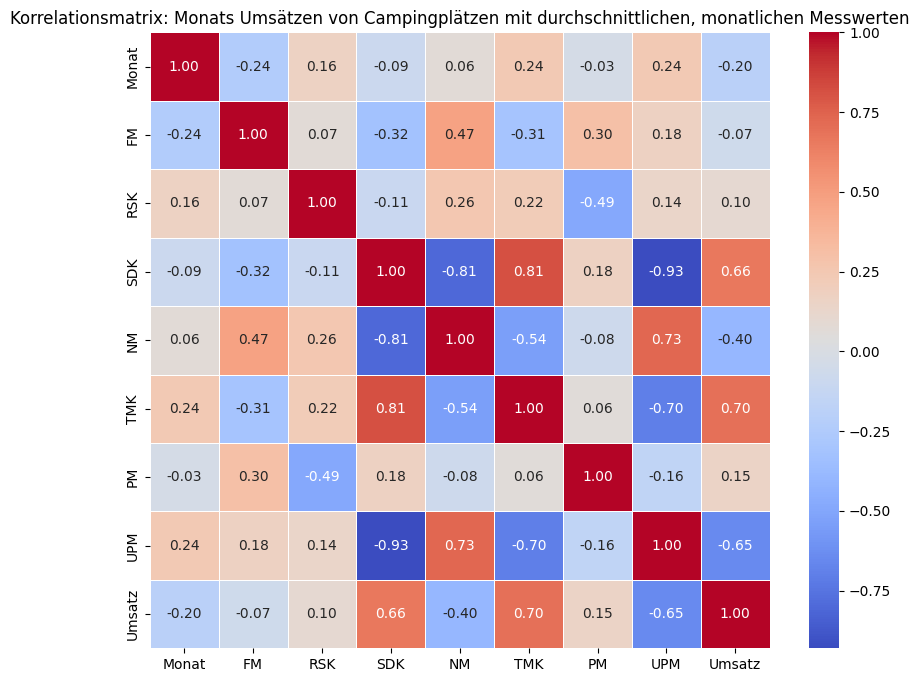

In [15]:
selected_columns = ['Monat', 'FM', 'RSK', 'SDK', 'NM', 'TMK', 'PM', 'UPM', 'Umsatz']
correlation_matrix = merged_df[selected_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Korrelationsmatrix: Monats Umsätzen von Campingplätzen mit durchschnittlichen, monatlichen Messwerten')

plt.show()


TMK = Tagesmittel der Lufttemperatur in 2m Höhe
SDK = tägliche Sonnenscheindauer
UPM = Tagesmittel der Relativen Feuchte
NM = Tagesmittel des Bedeckungsgrades

In [16]:
selected_columns = [ 'SDK', 'NM', 'TMK', 'UPM', 'Umsatz']
correlation_matrix = merged_df[selected_columns].corr()
selected_correlations = correlation_matrix['Umsatz'].drop('Umsatz')

selected_correlations = selected_correlations.rename({old_col: new_col for old_col, new_col in zip(selected_correlations.index, ['Sonnenscheindauer', 'Bedeckungsgrades', 'Lufttemperatur', 'Relativen Feuchte'])})

correlation_df = selected_correlations.reset_index()
correlation_df.columns = ['Spalte', 'Korrelation']

fig = px.bar(correlation_df, x='Spalte', y='Korrelation', color=correlation_df['Korrelation'] > 0,  
             color_discrete_map={True: 'red', False: 'blue'}, title='Die vier Messwerte mit dem höchsten Einfluss auf den Umsatz der Campingplätze')
fig.update_layout(xaxis_title='Messwert', yaxis_title='Korrelationskoeffizient')
fig.update_xaxes(categoryorder='total descending')
#pio.write_json(fig, "Top4Einfluss.json")
fig.show()


c:\Users\Ready2Go\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\express\_core.py:1985: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [17]:
merged_df['Zeitraum'] = pd.to_datetime(merged_df['Jahr'].astype(str) + '-' + merged_df['Monat'].astype(str), format='%Y-%m')
merged_df

merged_df['SDK_Relativ'] = (merged_df['SDK'] - merged_df['SDK'].iloc[0]) / merged_df['SDK'].iloc[0] * 100
merged_df['Umsatz_Relativ'] = (merged_df['Umsatz'] - merged_df['Umsatz'].iloc[0]) / merged_df['Umsatz'].iloc[0] * 100

fig = px.line(merged_df, x='Zeitraum', y=["SDK_Relativ", "Umsatz_Relativ"], 
              labels={'value': 'Prozentuale Veränderung', 'variable': 'Variable'},
              title='Relative Veränderung von Sonnenscheindauer und Umsatz')

fig.update_traces(name='Relative Sonnenstunden', selector=dict(name='SDK_Relativ'))
fig.update_traces(name='Relativer Umsatz', selector=dict(name='Umsatz_Relativ'))
fig.add_vline(x=pd.to_datetime('2002-08-01'), line_dash="dash", line_color="green")
fig.add_vline(x=pd.to_datetime('2006-07-01'), line_dash="dash", line_color="green")
#pio.write_json(fig, "VerlaufSonnenUmsatz.json")
fig.show()


c:\Users\Ready2Go\AppData\Local\Programs\Python\Python310\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [18]:
avg_umsatz_pro_jahr = merged_df.groupby('Jahr')['UPM'].mean().reset_index()


fig = px.line(merged_df, x='Zeitraum', y="UPM",  
              labels={'value': 'Prozentuale Veränderung', 'variable': 'Variable'},
              title='Entwicklung der Feuchtigkeit')

fig.add_trace(px.line(avg_umsatz_pro_jahr, x='Jahr', y='UPM',
                      labels={'UPM': 'Durchschnittliche Feuchtigkeit pro Jahr', 'Jahr': 'Jahr'}).data[0],)


fig.show()


c:\Users\Ready2Go\AppData\Local\Programs\Python\Python310\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [19]:
# merged_df['UPM_Relativ'] = (merged_df['UPM'] - merged_df['UPM'].iloc[0]) / merged_df['UPM'].iloc[0] * 100
# merged_df['Umsatz_Relativ'] = (merged_df['Umsatz'] - merged_df['Umsatz'].iloc[0]) / merged_df['Umsatz'].iloc[0] * 100

fig = px.line(merged_df, x='Zeitraum', y=["UPM", "Umsatz"], 
              labels={'value': 'Prozentuale Veränderung', 'variable': 'Variable'},
              title='Relative Veränderung von Feuchtigkeit und Umsatz')

fig.update_traces(name='Relative Feuchtigkeit', selector=dict(name='UPM'))
fig.update_traces(name='Relativer Umsatz', selector=dict(name='Umsatz'))
fig.add_vline(x=pd.to_datetime('2002-08-01'), line_dash="dash", line_color="green")
fig.add_vline(x=pd.to_datetime('2006-07-01'), line_dash="dash", line_color="green")
#pio.write_json(fig, "VerlaufFeuchtigkeitUmsatz.json")
fig.show()

c:\Users\Ready2Go\AppData\Local\Programs\Python\Python310\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [20]:
# empty DataFrame
accuracy_df = pd.DataFrame(columns=['Month', 'Accuracy'])

# Loop through all months
for month in range(1, 13):

    monthly_data = merged_df[merged_df['Datum'].dt.month == month].copy()

    # Average values for Temperature and Sales
    average_tmk_month = monthly_data['SDK'].mean()
    average_sales_month = monthly_data['Umsatz'].mean()

    # Count: Temperature and Sales are below/ above their average
    both_below_average = ((monthly_data['SDK'] < average_tmk_month) & (monthly_data['Umsatz'] < average_sales_month)).sum()
    both_above_average = ((monthly_data['SDK'] > average_tmk_month) & (monthly_data['Umsatz'] > average_sales_month)).sum()

    total_occurrences = len(monthly_data)

    accuracy = (both_below_average + both_above_average) / total_occurrences

    accuracy_df = pd.concat([accuracy_df, pd.DataFrame({'Month': [month], 'Accuracy': [accuracy]})], ignore_index=True)


fig = px.bar(accuracy_df, x='Month', y='Accuracy',
             title= 'Accuracy for each month')

fig.add_hline(y=0.5, line_dash="dash", line_color="black", annotation_text="Accuracy = 0.5",
              annotation_position="top left")

fig.show()

avg_accuracy = accuracy_df.Accuracy.mean()
print(f'On average, the accuracy is {round(avg_accuracy, 4)}')

C:\Users\Ready2Go\AppData\Local\Temp\ipykernel_17180\3613923011.py:21: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



On average, the accuracy is 0.523
